# Utils

In [ ]:
#| default_exp utils

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.vision.all import *
from torchvision.models.feature_extraction import create_feature_extractor

from fastai_datasets.all import *

In [ ]:
#| export
def as_percentage(x, ndigits=2):
    return f'{round(x * 100, ndigits=ndigits)}%'

In [ ]:
#| export
def cut_model_by_name(model, cut):
    graph = create_feature_extractor(model, [cut])
    base_forward = graph.forward
    graph.forward = lambda *args, **kwargs: base_forward(*args, **kwargs)[cut]
    return graph

In [ ]:
classifier = resnet34()
body = cut_model_by_name(classifier, 'avgpool')
test(body, 'avgpool', hasattr)
assert not hasattr(body, 'fc')

In [ ]:
#| export
class MLP(Module):
    """
    A Multilayer Perceptron comprized of linear layers with ReLU activations.
    """
    def __init__(self,
                 logits: Optional[int], # Number of logits. pass `None` to not include a logits layer after the hidden layers
                 hidden_depth=5, # Number of hidden layers
                 hidden_width=512, # Number of neurons in each hidden layer
                 features_dim=None  # Number of neurons in the last hidden layer. Pass `None` to use the same value as the other hidden layers
                 ):
        super().__init__()
        features_dim = features_dim or hidden_width

        def generate_hidden_layers():
            if hidden_depth == 0:
                return
            if hidden_depth >= 2:
                yield nn.LazyLinear(hidden_width)
                yield nn.ReLU()
                for _ in range(hidden_depth - 2):
                    yield nn.Linear(hidden_width, hidden_width)
                    yield nn.ReLU()
            yield nn.LazyLinear(features_dim)

        self.hidden_layers = nn.Sequential(*generate_hidden_layers())
        self.logits = nn.LazyLinear(logits) if logits else None

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.hidden_layers(x)
        if self.logits:
            x = self.logits(x)
        return x

In [ ]:
#| export
import torch
from torch import nn

from fastai.vision.all import *

class Threshold(nn.Module):
    """Classifies 1D inputs into 2 classes, based on whether they surpass a threshold or not"""
    def __init__(self) -> None:
        super().__init__()
        self.t = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = x - self.t
        return torch.stack([x, -x], dim=-1)

In [ ]:
threshold = Threshold()
with torch.no_grad():
    threshold.t[0] = 3

test_eq(threshold(torch.arange(10)).argmax(1), torch.tensor([1]*3+[0]*7))

Since this is such a simple model, we can fit it to data without iterative optimization:

In [ ]:
#| export
@patch
def fit(self: Threshold, x, y):
    """Picks a threshold that maximizes the empirical accuracy"""
    with torch.no_grad():
        def accuracy_for_threshold(t):
            self.t[0] = t
            return accuracy(self(x), y)

        threshold_candidates = np.arange(0.0, 4.0, 0.01)
        self.t[0], accuracy_score = max(((t, accuracy_for_threshold(t)) for t in threshold_candidates),
                                                key=lambda p: p[1])

        return self.t.item(), accuracy_score.item()


In [ ]:
threshold = Threshold()
x = torch.randint(high=10, size=(100,))
chosen_threshold, _ = threshold.fit(x, x < 3)

test_close(chosen_threshold, 3, eps=1)

## Experiments

Sometimes we want to test a certain procedure (e.g. training a model) multiple times, examine the distribution of the resulting stats. For example, we might want to train and test the same model on different train-test splits, or even the same split to examine the effect of training stochasticity on the results.

While tools like TensorBoard can be used for an in-depth analysis of the whole process (e.g. loss-by-epoch graphs), sometimes we just want to note the distribution of the end results.

Averaging over multiple runs also gives more stable results, for example cross-validation gives a more accurate estimate to the model's performance than training once.

In [ ]:
#| export
from abc import ABC, abstractmethod
from dataclasses import dataclass

import matplotlib.pyplot as plt
    

@dataclass
class ExperimentalResults(object):
    "Provides various ways of examining the results of a `RepeatedExperiment`"
    stats: List[Any]

    @property
    def collated_stats(self):
        return {k: v.numpy() for k, v in default_collate(self.stats).items()}

    def plot_stats(self):
        fig, axs = plt.subplots(len(self.collated_stats), sharex=True)
        fig.tight_layout()
        for ax, (stat_name, stat_values) in zip(axs, self.collated_stats.items()):
            ax.set_title(stat_name)

            min_val, max_val = min(stat_values), max(stat_values)
            val_range = max_val - min_val
            ax.set_ylim(min_val - .1*val_range, max_val + .1*val_range)
            
            ax.bar(range(len(stat_values)), stat_values)

    @property
    def stat_means(self):
        return {k: v.mean() for k, v in self.collated_stats.items()}

    @property
    def stat_stds(self):
        return {k: v.std() for k, v in self.collated_stats.items()}


class RepeatedExperiment(ABC):
    "Runs multiple independent iterations of the same procedure, and combines the results"

    def __init__(self,
                 model: nn.Module,  # The model to be used in each iteration. Parameter are reset to their initial values before each iteration
                 data: List[Datasets],  # A list of `Datasets`, each representing a different iteration. A `Dataloaders` of the current `Datasets` is available via `self.dls`
                 seed: int = 0  # Used for reproducibility of results. Use `None` to avoid reproducibility
                 ):
        super().__init__()
        store_attr('model, data, seed')
    
    def run(self) -> ExperimentalResults:
        "Runs the experiment, returning the results as an `ExperimentalResults`"
        return ExperimentalResults(self._run())

    @return_list
    def _run(self):
        if self.seed is not None:
            set_seed(self.seed, reproducible=True)

        initial_state_dict = deepcopy(self.model.state_dict())

        splits = master_bar(self.data)
        for i, split in enumerate(splits):
            self.dls = split.dls()
            yield self.iteration()
            self.model.load_state_dict(initial_state_dict)

    @abstractmethod
    def iteration(self) -> Dict[str, Any]:
        pass

In [ ]:
show_doc(RepeatedExperiment.run)

---

[source](https://github.com/Irad-Zehavi/similarity-learning/blob/main/similarity_learning/utils.py#L137){target="_blank" style="float:right; font-size:smaller"}

### RepeatedExperiment.run

>      RepeatedExperiment.run ()

Runs the experiment, returning the results as an `ExperimentalResults`

For example, we can train a linear classifier for `MNIST` multiple times and check distribution of accuracies:

In [ ]:
class LinearMNIST(RepeatedExperiment):
    def iteration(self):
        learn = Learner(self.dls, self.model, metrics=accuracy)
        learn.fit(1)
        return dict(zip(['loss', 'accuracy'], learn.validate()))
    
res = LinearMNIST(model=nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2)),
                  data=[TinyMNIST() for _ in range(10)]).run()

In [ ]:
res.stats

[{'loss': 0.3591866195201874, 'accuracy': 0.9742489457130432},
 {'loss': 0.34896886348724365, 'accuracy': 0.9756795167922974},
 {'loss': 0.3619726896286011, 'accuracy': 0.9771101474761963},
 {'loss': 0.3663684129714966, 'accuracy': 0.9756795167922974},
 {'loss': 0.35216033458709717, 'accuracy': 0.9756795167922974},
 {'loss': 0.35451024770736694, 'accuracy': 0.9771101474761963},
 {'loss': 0.35790905356407166, 'accuracy': 0.9742489457130432},
 {'loss': 0.3541954755783081, 'accuracy': 0.9756795167922974},
 {'loss': 0.3539672791957855, 'accuracy': 0.9771101474761963},
 {'loss': 0.3568763732910156, 'accuracy': 0.9771101474761963}]

In [ ]:
show_doc(ExperimentalResults.collated_stats)

---

[source](https://github.com/Irad-Zehavi/similarity-learning/blob/main/similarity_learning/utils.py#L103){target="_blank" style="float:right; font-size:smaller"}

### ExperimentalResults.collated_stats

>      ExperimentalResults.collated_stats ()

In [ ]:
res.collated_stats

{'loss': array([0.35918662, 0.34896886, 0.36197269, 0.36636841, 0.35216033,
        0.35451025, 0.35790905, 0.35419548, 0.35396728, 0.35687637]),
 'accuracy': array([0.97424895, 0.97567952, 0.97711015, 0.97567952, 0.97567952,
        0.97711015, 0.97424895, 0.97567952, 0.97711015, 0.97711015])}

In [ ]:
show_doc(ExperimentalResults.plot_stats)

---

[source](https://github.com/Irad-Zehavi/similarity-learning/blob/main/similarity_learning/utils.py#L106){target="_blank" style="float:right; font-size:smaller"}

### ExperimentalResults.plot_stats

>      ExperimentalResults.plot_stats ()

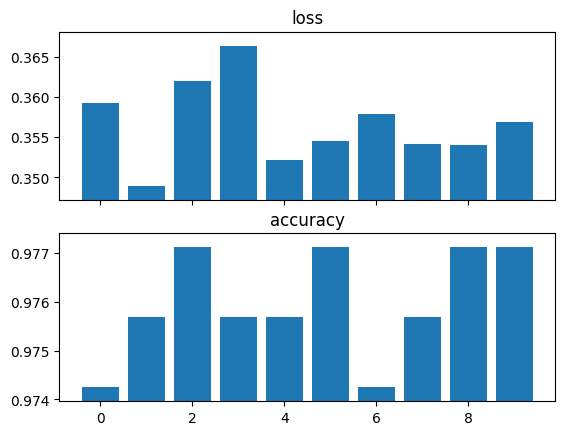

In [ ]:
res.plot_stats()

In [ ]:
show_doc(ExperimentalResults.stat_means)

---

[source](https://github.com/Irad-Zehavi/similarity-learning/blob/main/similarity_learning/utils.py#L118){target="_blank" style="float:right; font-size:smaller"}

### ExperimentalResults.stat_means

>      ExperimentalResults.stat_means ()

In [ ]:
res.stat_means

{'loss': 0.35661153495311737, 'accuracy': 0.9759656548500061}

In [ ]:
show_doc(ExperimentalResults.stat_stds)

---

[source](https://github.com/Irad-Zehavi/similarity-learning/blob/main/similarity_learning/utils.py#L122){target="_blank" style="float:right; font-size:smaller"}

### ExperimentalResults.stat_stds

>      ExperimentalResults.stat_stds ()

In [ ]:
res.stat_stds

{'loss': 0.004772754486396994, 'accuracy': 0.0010705668573123257}

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()